In [0]:
import matplotlib.pyplot as plt

## # **Cargar Capa Gold 🥇**

In [0]:
df = spark.table("workspace.default.fraude_gold")


## ANALISIS DE FRAUDE 🧐

In [0]:
#¿Cuántas operaciones se analizaron en total?
total_transacciones = df.count()
total_transacciones

200000

In [0]:
#¿Qué proporción de las transacciones son sospechosas?
fraudes = df.filter(df.es_fraude == 1).count()
porcentaje_fraude = (fraudes / total_transacciones) * 100

fraudes, porcentaje_fraude

(3000, 1.5)

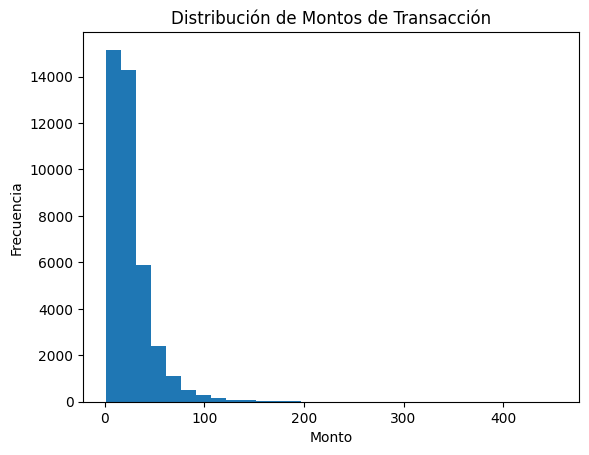

In [0]:
#¿En qué rangos de monto se concentran las transacciones?
montos = df.select("monto").sample(fraction=0.2).toPandas()

plt.figure()
plt.hist(montos["monto"], bins=30)
plt.title("Distribución de Montos de Transacción")
plt.xlabel("Monto")
plt.ylabel("Frecuencia")
plt.show()

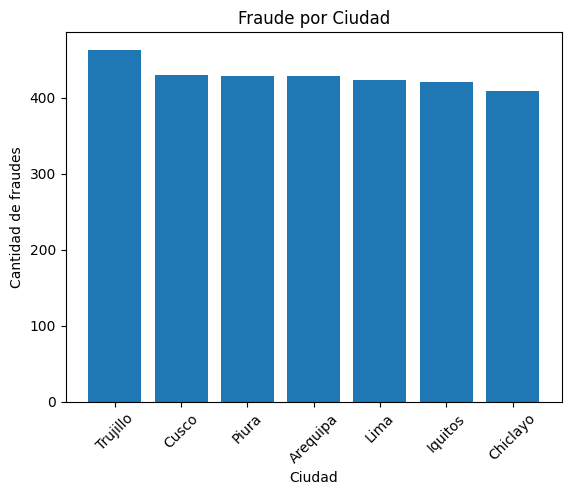

In [0]:
#¿Dónde ocurre más fraude?
fraude_ciudad = (
    df.filter(df.es_fraude == 1)
      .groupBy("ciudad_transaccion")
      .count()
      .orderBy("count", ascending=False)
      .limit(10)
      .toPandas()
)

plt.figure()
plt.bar(fraude_ciudad["ciudad_transaccion"], fraude_ciudad["count"])
plt.title("Fraude por Ciudad")
plt.xlabel("Ciudad")
plt.ylabel("Cantidad de fraudes")
plt.xticks(rotation=45)
plt.show()

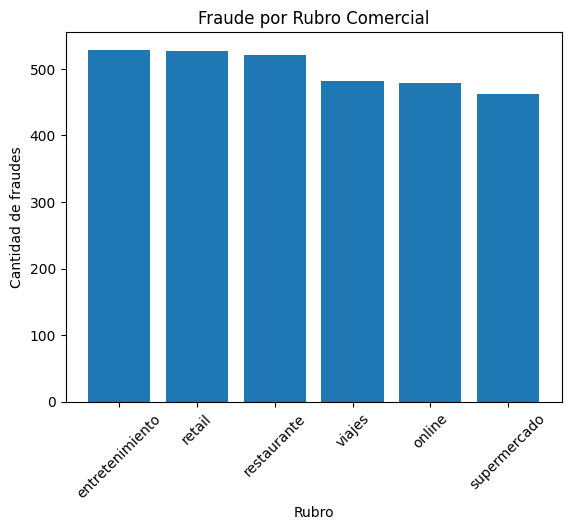

In [0]:
  #¿Qué tipo de comercio es más vulnerable?
fraude_rubro = (
    df.filter(df.es_fraude == 1)
      .groupBy("rubro")
      .count()
      .orderBy("count", ascending=False)
      .limit(10)
      .toPandas()
)   

plt.figure()
plt.bar(fraude_rubro["rubro"], fraude_rubro["count"])
plt.title("Fraude por Rubro Comercial")
plt.xlabel("Rubro")
plt.ylabel("Cantidad de fraudes")
plt.xticks(rotation=45)
plt.show()


## Análisis con Machine Learning

In [0]:
# 🔍 Seleccionamos únicamente las columnas que usará el modelo
# Estas columnas serán las VARIABLES EXPLICATIVAS (features)
# y la variable objetivo (label)

df_ml = df.select(
    "monto",           # 💰 Monto de la transacción
    "limite_credito",  # 💳 Límite de la tarjeta
    "edad",            # 👤 Edad del cliente
    "es_principal",    # 📱 Si el dispositivo es principal (1 = sí, 0 = no)
    "es_fraude"        # 🚨 Variable objetivo (fraude o no)
)


In [0]:
from pyspark.ml.feature import VectorAssembler

# 🧩 Spark ML exige que todas las variables estén
# dentro de una sola columna vectorial llamada "features"

assembler = VectorAssembler(
    inputCols=["monto", "limite_credito", "edad", "es_principal"],  # 🎯 Features
    outputCol="features"                                           # 📦 Vector final
)

# 🔄 Convertimos columnas sueltas en un vector numérico
df_ml = assembler.transform(df_ml)

# 🏷️ Renombramos la variable objetivo como "label"
# (Spark ML exige este nombre)
df_ml = df_ml.withColumnRenamed("es_fraude", "label")


In [0]:
# ✂️ Dividimos la data:
# 80% para entrenar el modelo
# 20% para evaluar su desempeño

train, test = df_ml.randomSplit([0.8, 0.2], seed=42)

In [0]:
from pyspark.ml.classification import LogisticRegression

# 🤖 Creamos el modelo de Regresión Logística
# Ideal para problemas binarios (fraude / no fraude)

lr = LogisticRegression(
    featuresCol="features",  # 📦 Variables explicativas
    labelCol="label"         # 🎯 Variable objetivo
)

# 🏋️ Entrenamos el modelo con los datos de entrenamiento
model = lr.fit(train)

In [0]:
# 🔮 Aplicamos el modelo entrenado sobre los datos de prueba
predictions = model.transform(test)

# 👀 Mostramos:
# - valor real (label)
# - predicción del modelo
# - probabilidad estimada
predictions.select(
    "label", 
    "prediction", 
    "probability"
).show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.98600764603817...|
|    0|       0.0|[0.99395654842496...|
|    0|       0.0|[0.99348606940120...|
|    0|       0.0|[0.99376301307737...|
|    0|       0.0|[0.99388725262988...|
|    0|       0.0|[0.99400388642055...|
|    0|       0.0|[0.98558685991623...|
|    0|       0.0|[0.98582990404520...|
|    0|       0.0|[0.99405480356839...|
|    0|       0.0|[0.99371576397784...|
+-----+----------+--------------------+
only showing top 10 rows


In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# 📊 Evaluador para clasificación binaria
# Usamos AUC (Area Under the Curve)

evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# 📈 Calculamos el AUC
auc = evaluator.evaluate(predictions)

print("AUC:", auc)

AUC: 0.6802660126166651


In [0]:
# 📋 Conteo de predicciones vs realidad
# Nos permite ver errores del modelo

predictions.groupBy(
    "label",       # 🎯 Valor real
    "prediction"   # 🤖 Valor predicho
).count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|39550|
|    0|       1.0|    5|
|    1|       0.0|  618|
|    1|       1.0|    1|
+-----+----------+-----+

